### Importing the libararies

In [1]:
!pip install annoy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import collections

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style("darkgrid")

import torch
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data.dataset import Dataset

from PIL import Image

from annoy import AnnoyIndex

### This will create the dataframe, that we will use for loading images in ImageDataset

In [3]:
def get_files_from_path(pathstring):

    filenames = []
    for file in Path(pathstring).glob("**/*.jpg"):
        filenames.append((file, file.stat().st_size))
    files_df = pd.DataFrame(list(filenames),
                            columns=["path", "filesize"])
    sorted_files = files_df.sort_values("path")
    result_df = sorted_files.reset_index(drop=True)
    return result_df

### Here we are defining the Dataset, we have to normalize the images, as they  are expected by all these trained models

In [4]:
class ImageDataset(Dataset):

    transform = None

    def __init__(self, path, img_size):
        self.df_files = get_files_from_path(path)
        self.transform = transforms.Compose([
            transforms.Resize(img_size, Image.ANTIALIAS),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])
        
    def __getitem__(self, index):        
        data = Image.open(self.df_files.iloc[index].path, 'r')
        data = data.convert('RGB')
        tensor = self.transform(data)
        return tensor, index

    def __len__(self):
        return self.df_files.shape[0]

    def get_file_df(self):
        return self.df_files

In [5]:
def plots(indices, pd, figsize=(12,6), rows=1, titles=None, title=None):
    """
    Custom plot function to summarize the reverse image search results 
    """
    f = plt.figure(figsize=figsize)
    plt.subplots_adjust(left=0.1, bottom=0, right=0.2, top=1.02, wspace=0.02, hspace=0.02)
    plt.axis('Off')
    cols = len(indices)//rows if len(indices) % rows == 0 else len(indices)//rows + 1
    for i, img_idx in enumerate(indices):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        sp.get_xaxis().set_visible(False)
        sp.get_yaxis().set_visible(False)
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        data = Image.open(pd.iloc[img_idx].path, 'r')
        data = data.convert('RGB')
        data = data.resize((400,200), Image.ANTIALIAS)
        plt.imshow(data)
        plt.tight_layout()
    plt.autoscale(tight=True)
    if title is not None:
        plt.suptitle(title, size=32)
        f.tight_layout()
        f.subplots_adjust(top=0.94)
        plt.show()     

### This function will make the AnnoyIndex

In [6]:
def getVectorIndex(model, image_loader):

    t = AnnoyIndex(1000) # This is the no of features, per image
    with torch.no_grad():
        model.eval()
        for batch_idx, (data, target) in enumerate(image_loader):
            if cuda:
                data = data.cuda()
            outputs = model(data)
            for i in range(0, len(data)):
                t.add_item(target[i], outputs[i])
    t.build(20) # Here we specify the no of trees
    return t

In [7]:
def get_similar(item_no, annoyIndex):

    return annoyIndex.get_nns_by_item(item_no, 5, include_distances=False)  # 5 is ithe no of neighbors to return

def plot_similar(indices, annoyIndex, pd):
    nn_output = [get_similar(i, annoyIndex) for i in indices ]
    flat_list = np.asarray(nn_output).transpose().reshape(-1).tolist()
    plots(flat_list, pd, figsize=(26,22), rows=5)


In [8]:
def compare_networks(index, annoyIndexes, pd):
    """ Plots nearest neighbors for query image for 
    multiple annoyIndexes. We compare and contrast the
    results of various techniques using this.

    Arguments:
        index -- index of the image to use for query.         
        annoyIndexes -- pytorch image_loader        
        pd -- pandas dataframe
    """


    nn_output = [get_similar(index, annoyIndex) for annoyIndex in annoyIndexes ]
    flat_list = np.asarray(nn_output).transpose().reshape(-1).tolist()
    title = "Nearby results: alexnet, vgg19"
    plots(flat_list, pd, figsize=(26,14), rows=5, title=title)

In [9]:
input_folder='TOTAL-DATA/5000-data/images/'
imgnet_size=(224,224)
inception_imgnet_size=(299,299) 
input_dataset = ImageDataset(input_folder, img_size=imgnet_size)
pd_files = input_dataset.get_file_df()
cuda = torch.cuda.is_available()
bs = 100
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
image_loader = torch.utils.data.DataLoader(input_dataset, batch_size=bs,**kwargs)

In [10]:
len(input_dataset)

5000

### Loading Different pretrained models for comparison

In [11]:
alexnet = models.alexnet(pretrained=True)
vgg19 = models.vgg19(pretrained=True)
#resnet152 = models.resnet152(pretrained=True)
#densenet = models.densenet201(pretrained=True)
#inception = models.inception_v3(pretrained=True)

models = [ alexnet, vgg19]

cuda_eval_models = [model.cuda() if cuda else model for model in models]

In [12]:
%%time
annoy_indexes = [getVectorIndex(model, image_loader) for model in cuda_eval_models]

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  app.launch_new_instance()


CPU times: user 4min 18s, sys: 33.9 s, total: 4min 52s
Wall time: 4min 52s


#### In indices we can choose to pick which image from random samples

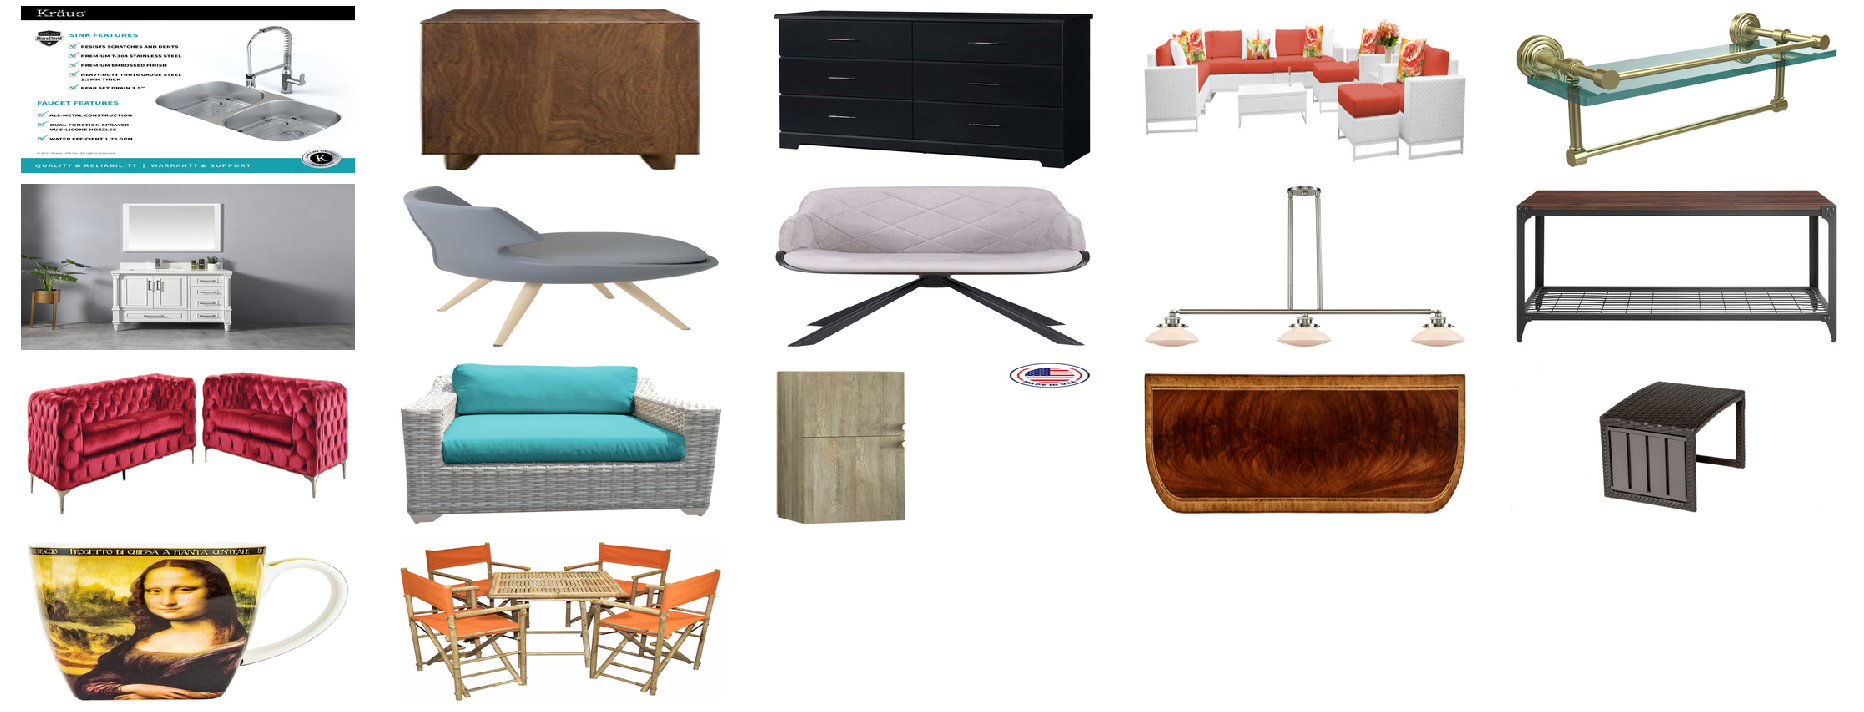

In [14]:

random_samples = [1390, 2, 1188, 645, 1476, 1154, 582, 1801, 184, 1047, 1198, 93, 1953, 1082, 1533, 595, 137]
indices = [0, 3, 6, 9, 4]

plots(random_samples, pd_files, figsize=(26,10), rows=4)

random_samples = np.asarray(random_samples)[indices].tolist()


### We are going to check for these samples

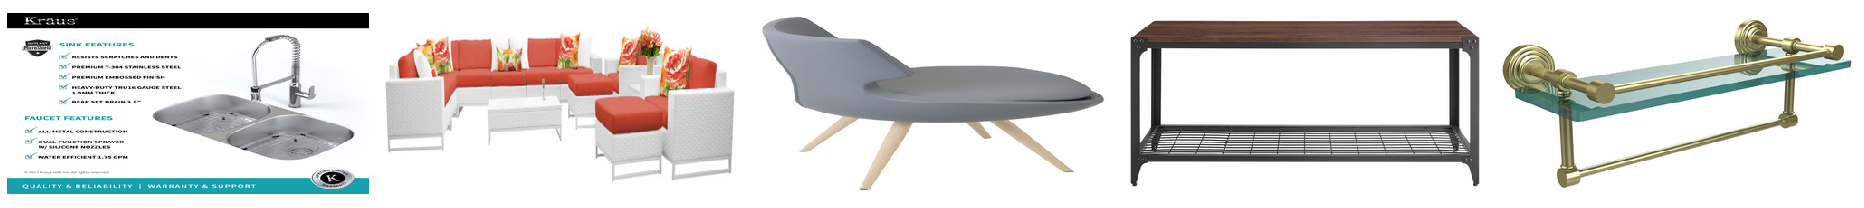

In [15]:
plots(random_samples, pd_files, figsize=(26,3), rows=1)

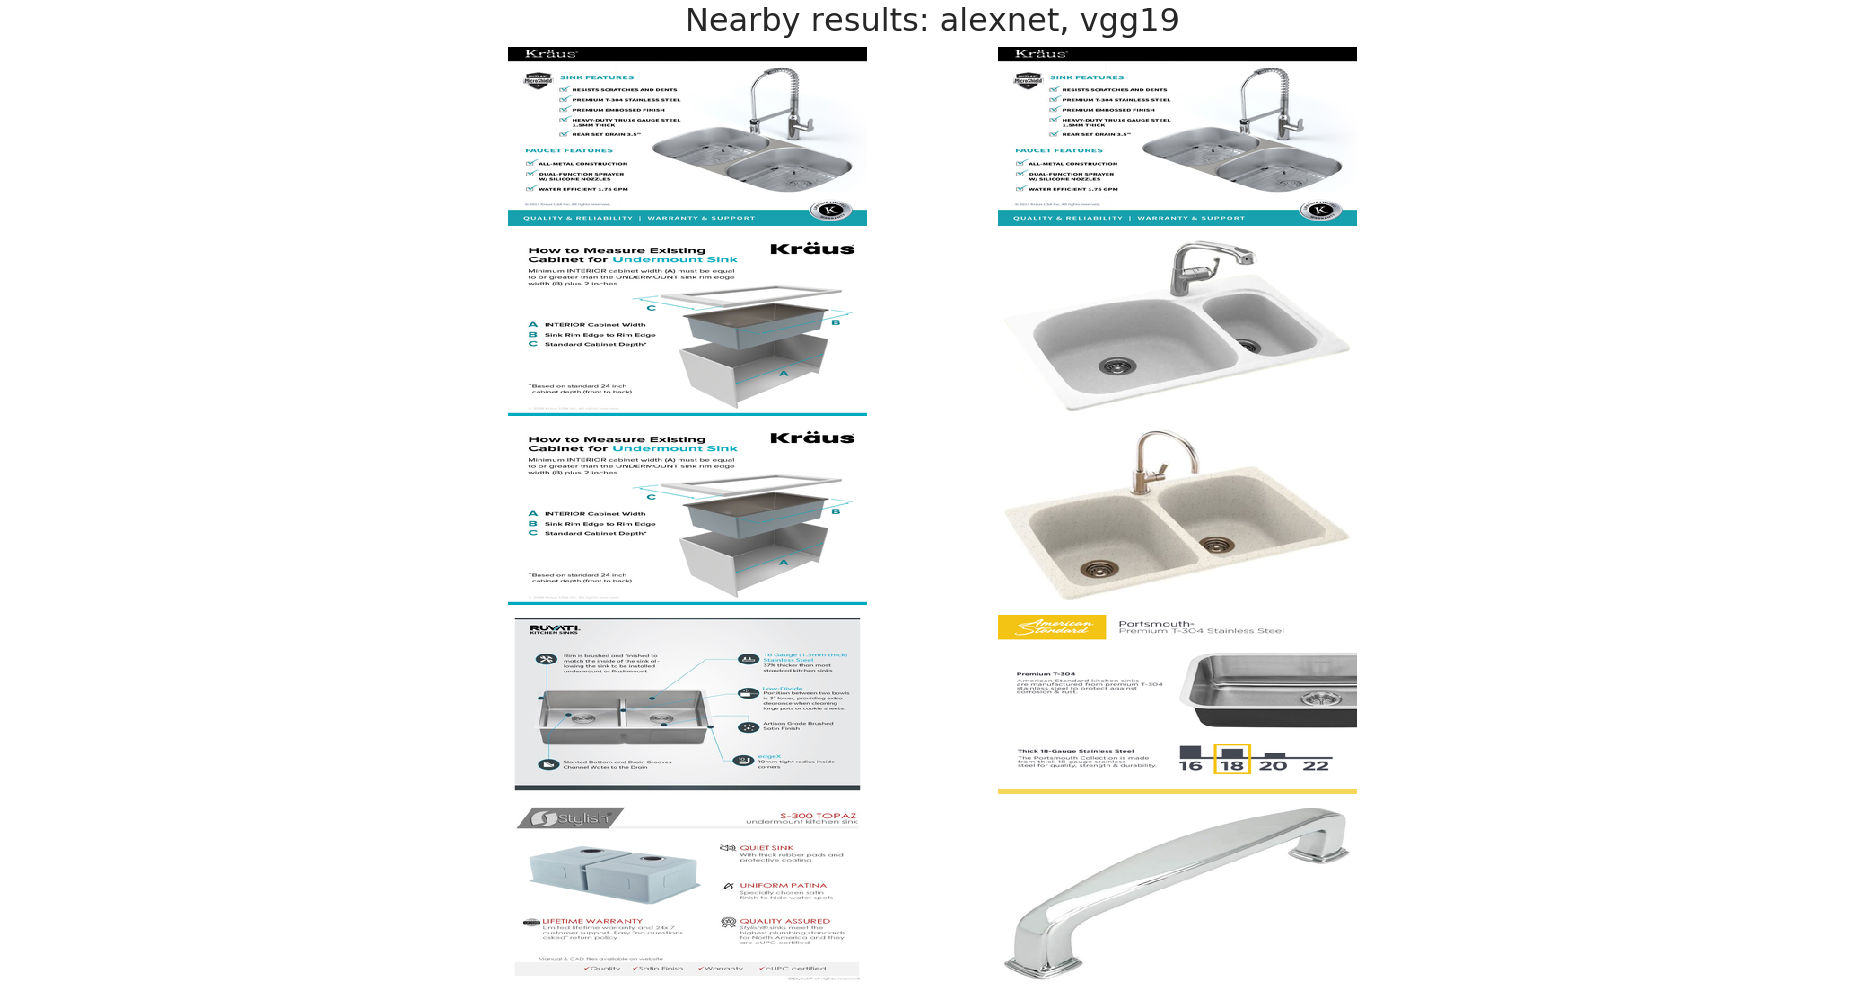

In [16]:
compare_networks(random_samples[0], annoy_indexes, pd_files)

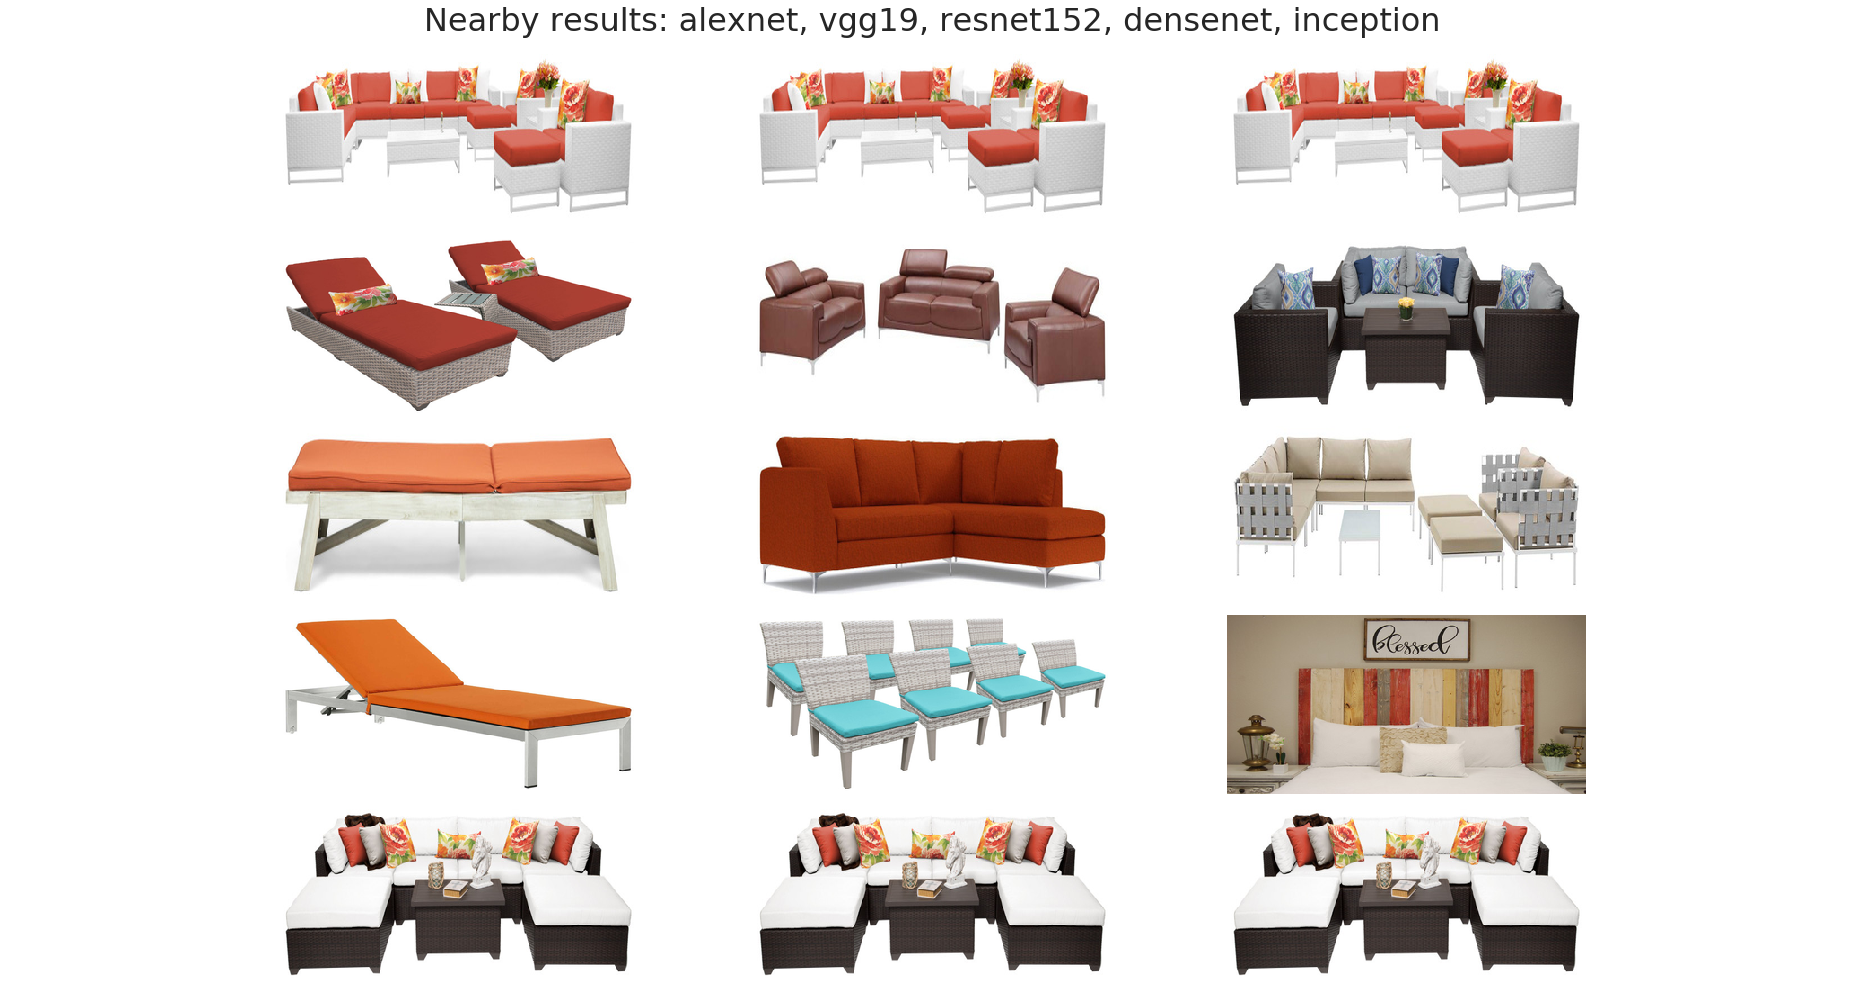

In [18]:
compare_networks(random_samples[1], annoy_indexes, pd_files)

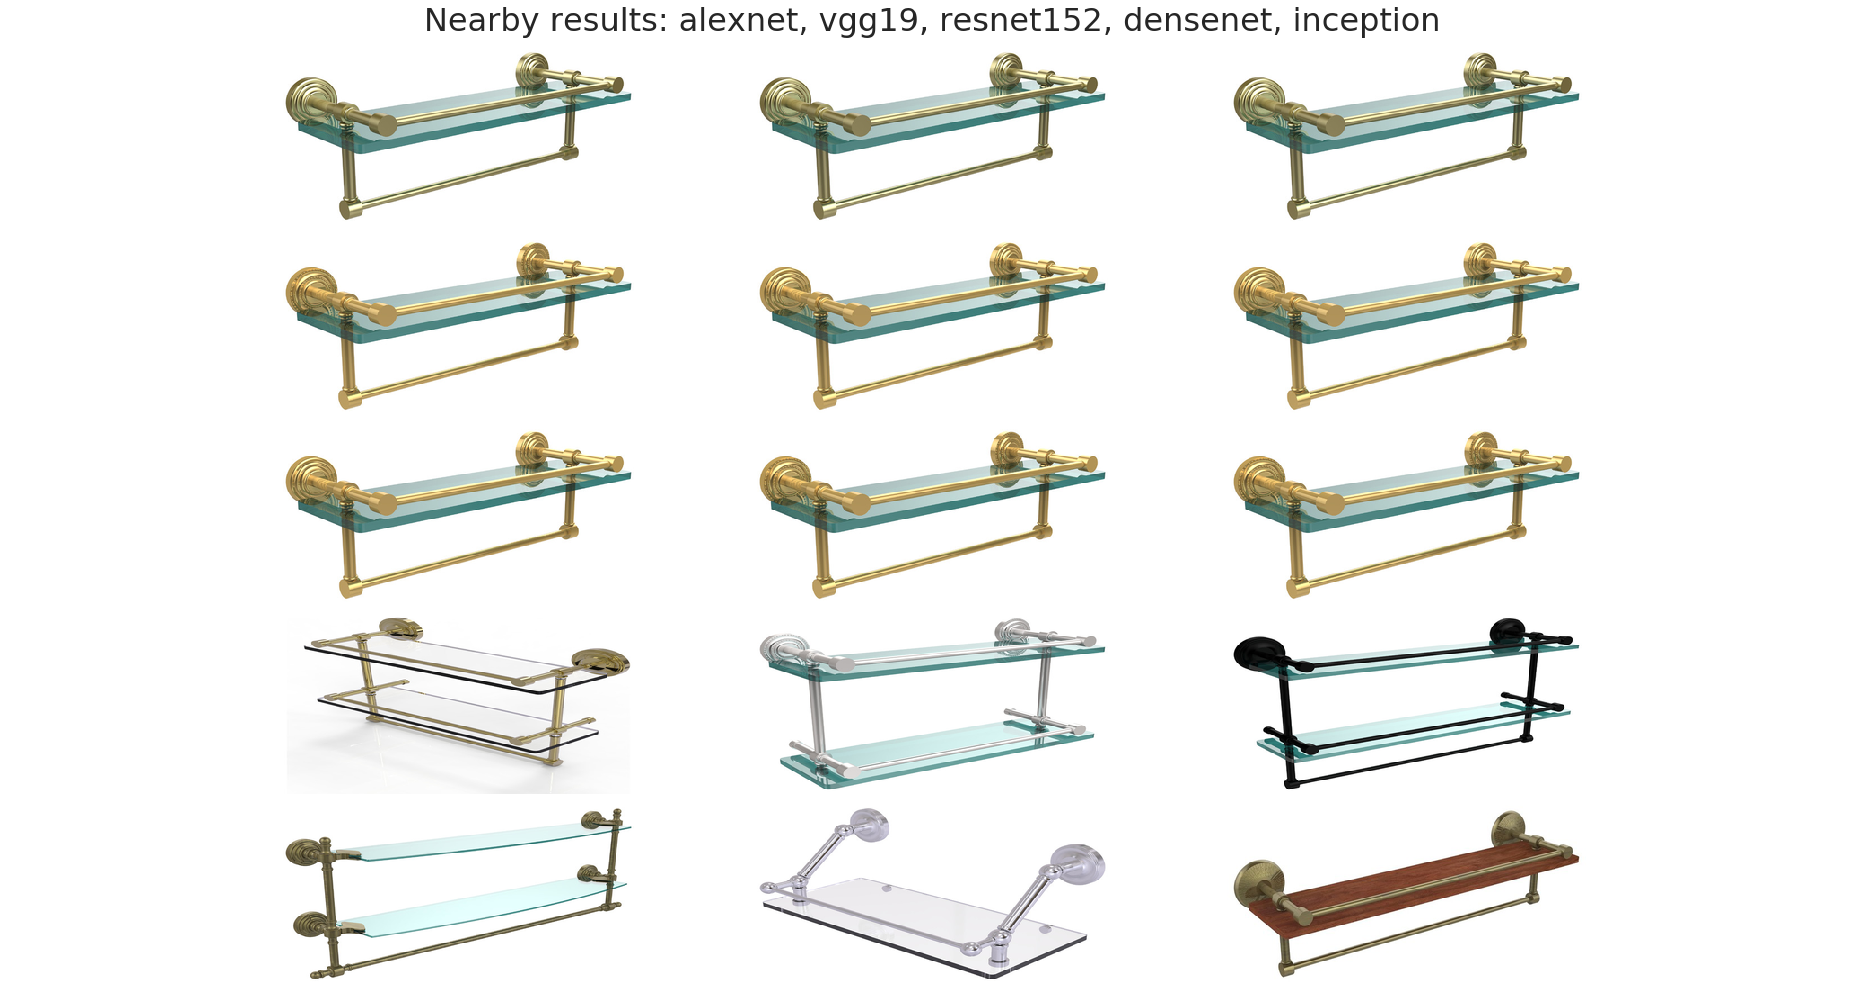

In [20]:
compare_networks(random_samples[4], annoy_indexes, pd_files)